In [1]:
import tinygp
from tinygp import kernels, GaussianProcess

import jax
import jax.numpy as jnp
import jaxopt
jax.config.update("jax_enable_x64", True)
from functools import partial
import numpy as np

import matplotlib.pyplot as plt

In [2]:
y = np.array([25.539724,34.43329,41.006016,52.113163,61.783413,78.87466,109.70418,152.17516,203.90158,266.6001,369.8482,432.67142,538.5478,625.7944,650.8599,711.9242,840.75073,912.17755,1033.8127,1254.5685,1488.9216,1594.7357,1734.7332,1891.2493,1945.0106,2000.462,2096.1748,2112.089,2184.8262,2225.8442,2322.396,2406.801,2390.2766,2431.4219,2523.9526,2507.43,2573.71,2601.89,2577.71,2682.73,2686.95,2721.42,2666.92,2656.04,2619,2686.44,2575.34,2403.09,2418.07,2472.35,2502.15,2539.93,2565.63,2618.98,2723.54,2634.15,2738.44])
x = np.linspace(1965, 2021, len(y))

(1965.0, 2021.0)

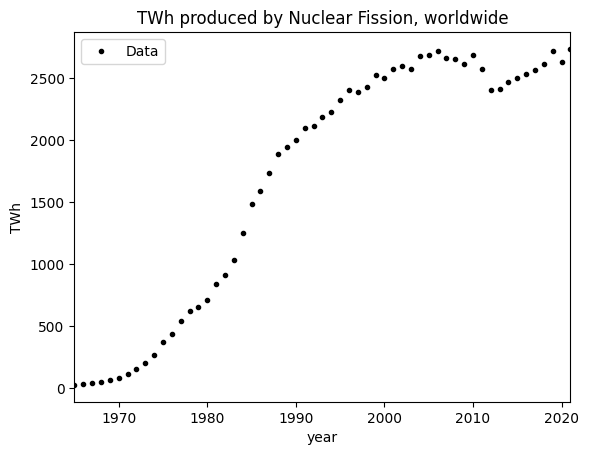

In [3]:
plt.plot(x, y, "k.", label="Data")
plt.xlabel("year"); plt.ylabel("TWh"); plt.legend(); plt.title("TWh produced by Nuclear Fission, worldwide")
plt.xlim(min(x), max(x))

In [4]:
def logistic_model(param_log, x=x):
    denom = 1 + jnp.exp(param_log["b"] * (x - param_log["c"]))
    m = param_log["a"] / denom
    return m

@jax.jit
def loss_log(param_log): 
    return jnp.sum(jnp.square(logistic_model(param_log, x) - y))

param_log = { # initial parameters, estimated by eye
    "a": 2500., 
    "b": -0.21,
    "c": 1980.,
}

(1965.0, 2021.0)

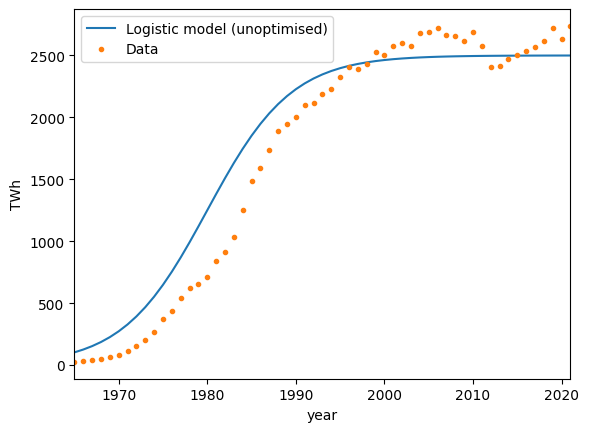

In [5]:
y_model = logistic_model(param_log, x)
plt.plot(x, y_model, label="Logistic model (unoptimised)")
plt.plot(x, y, ".", label="Data")
plt.xlabel("year"); plt.ylabel("TWh"); plt.legend(); plt.xlim(min(x), max(x))

In [6]:
solver_log = jaxopt.ScipyMinimize(fun=loss_log)
%time soln_log = solver_log.run(jax.tree_map(jnp.asarray, param_log))
soln_log.params

CPU times: user 274 ms, sys: 8.1 ms, total: 282 ms
Wall time: 98.1 ms


{'a': DeviceArray(2611.27367988, dtype=float64),
 'b': DeviceArray(-0.21101117, dtype=float64),
 'c': DeviceArray(1984.25887198, dtype=float64)}

(1965.0, 2021.0)

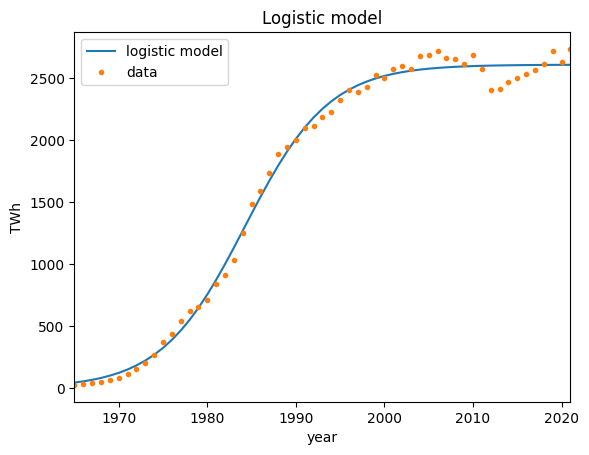

In [7]:
plt.plot(x, logistic_model(soln_log.params), label="logistic model")
plt.plot(x, y, ".", label="data")
plt.legend(); plt.xlabel("year"); plt.ylabel("TWh"); plt.title("Logistic model")
plt.xlabel("year"); plt.ylabel("TWh"); plt.legend(); plt.xlim(min(x), max(x))

(This obviously converged to 2500 

In [8]:
def build_gp(params: dict) -> GaussianProcess: 
    kernel = jnp.exp(params["log_amp"]) * kernels.ExpSquared(jnp.exp(params["log_scale"]))
    return GaussianProcess(kernel, x, diag=jnp.exp(params["log_diag"]) + jnp.exp(params["log_jitter"]))

@jax.jit
def loss(params: dict) -> float: 
    gp = build_gp(params)
    return -gp.log_probability(y)

In [9]:
params = {
    "log_amp": np.log(np.var(y)), 
    "log_scale": np.log(1.), 
    "log_diag": np.log(0.1), 
    "log_jitter": np.log(0.1),
    "log_matern_scale": np.log(1.0)
}
loss(params)

DeviceArray(472.61808292, dtype=float64)

In [10]:
def mean_function(mean_params, x): 
    logistic_model = 1+ jnp.exp(mean_params["b"] * (x-mean_params["c"]))
    return jnp.divide(mean_params["a"], logistic_model)

mean_params = soln_log.params

def build_gp_m(params_m) -> GaussianProcess: 
    kernel = jnp.exp(params["log_amp"]) * kernels.ExpSquared(jnp.exp(params["log_scale"]))
    kernel += kernels.Matern52(jnp.exp(params["log_matern_scale"]))
    return GaussianProcess(
        kernel, x, 
        diag=jnp.exp(params["log_diag"]), 
        mean=partial(mean_function, params)
    )

@jax.jit
def loss_m(params):
    gp = build_gp_m(params)
    return -gp.log_probability(y)

params = {
    **params, 
    **mean_params,
}

loss_m(params)

DeviceArray(427.37495296, dtype=float64)

In [11]:
params_m = {
    **params, 
    **mean_params}
params_m

{'log_amp': 13.818208936894733,
 'log_scale': 0.0,
 'log_diag': -2.3025850929940455,
 'log_jitter': -2.3025850929940455,
 'log_matern_scale': 0.0,
 'a': DeviceArray(2611.27367988, dtype=float64),
 'b': DeviceArray(-0.21101117, dtype=float64),
 'c': DeviceArray(1984.25887198, dtype=float64)}

In [12]:
t = np.linspace(1965, 2035, 200)

Verification that the mean function for the GP is the same as above, with optimised values (the optimisation may change the values)

(1965.0, 2021.0)

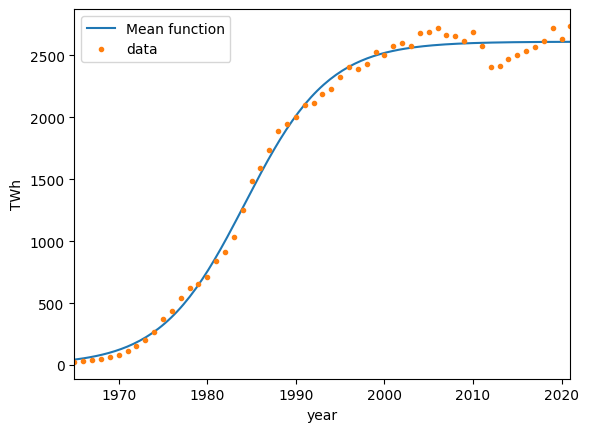

In [13]:
model = jax.vmap(partial(mean_function, mean_params))(t)
plt.plot(t, model, label="Mean function")
plt.plot(x, y, ".", label="data")
plt.xlabel("year"); plt.ylabel("TWh"); plt.legend(); plt.xlim(min(x), max(x))

In [14]:
print(f"Initial negative log likelihood: {loss_m(params)}")
solver = jaxopt.ScipyMinimize(fun=loss_m)
soln = solver.run(jax.tree_map(jnp.asarray, params))
print(f"Final negative log likelihood: {soln.state.fun_val}")

Initial negative log likelihood: 427.3749529590152
Final negative log likelihood: 427.3749529590152


(1965.0, 2035.0)

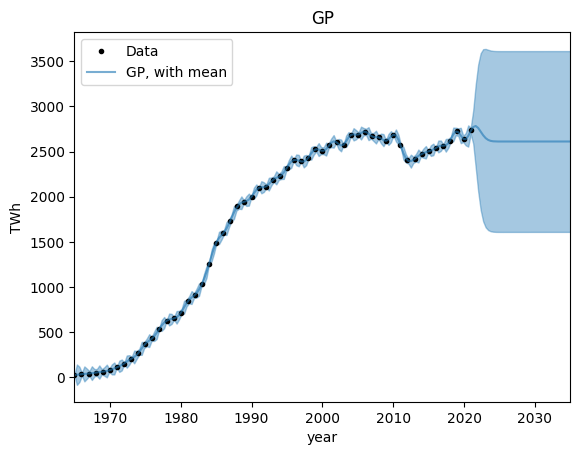

In [15]:
_, cond = build_gp_m(soln.params).condition(y, t)

mu, std = cond.loc, np.sqrt(cond.variance)
plt.plot(x, y, ".k", label="Data")
plt.plot(t, mu, color="C0", label="GP, with mean", alpha=0.6)
plt.fill_between(t, mu-std, mu+std, color="C0", alpha=0.4)
plt.legend(loc="upper left"); plt.xlabel("year"); plt.ylabel("TWh"); plt.title("GP"); plt.xlim(min(t), max(t))

Dissaggreagate the mean function and the residual

(1965.0, 2035.0)

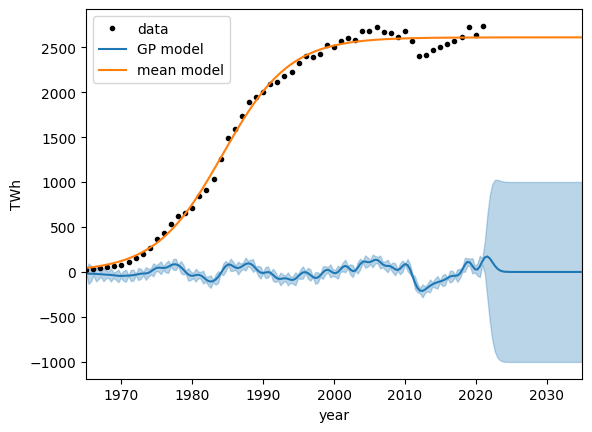

In [16]:
gp = build_gp_m(soln.params)
_, cond = gp.condition(y, t, include_mean=False)

mu = cond.loc #+ soln.params["b"]
std = np.sqrt(cond.variance)

plt.plot(x, y, ".k", label="data")
plt.plot(t, mu, label="GP model")
plt.fill_between(t, mu-std, mu+std, alpha=0.3, color="C0")
plt.plot(t, jax.vmap(gp.mean_function)(t), label="mean model")

plt.legend(); plt.xlabel("year"); plt.ylabel("TWh"); plt.xlim(min(t), max(t))

In [17]:
soln.params

{'a': DeviceArray(2611.27367988, dtype=float64),
 'b': DeviceArray(-0.21101117, dtype=float64),
 'c': DeviceArray(1984.25887198, dtype=float64),
 'log_amp': DeviceArray(13.81820894, dtype=float64),
 'log_diag': DeviceArray(-2.30258509, dtype=float64),
 'log_jitter': DeviceArray(-2.30258509, dtype=float64),
 'log_matern_scale': DeviceArray(0., dtype=float64),
 'log_scale': DeviceArray(0., dtype=float64)}